In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
from sklearn.utils import shuffle
from collections import OrderedDict
from collections import Counter
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.inspection import permutation_importance

In [2]:
# Data import

path = './dataset/BGL/BGL_readyToExploitData.csv'
data = pd.read_csv(path)
data_df = pd.DataFrame(data)
data_df.head()

,Session,EventSequence,Label
0,0,"['3aa50e45', '3aa50e45', '3aa50e45', '3aa50e45...",0
1,1,"['d3e73bc3', '60b301fc', 'd3e73bc3', 'd3e73bc3...",1
2,2,"['4983ff07', '4983ff07', '150b1306', '150b1306...",1
3,3,"['3aa50e45', '3aa50e45', 'ba77ab8e', 'ba77ab8e']",0
4,4,"['ba77ab8e', 'd3e73bc3', 'd3e73bc3', 'd3e73bc3...",0


In [3]:
# Shuffle and split the data
def _split_data(x_data, y_data, train_ratio=0.5):
    pos_idx = y_data > 0
    x_pos = x_data[pos_idx]
    y_pos = y_data[pos_idx]
    x_neg = x_data[~pos_idx]
    y_neg = y_data[~pos_idx]
    train_pos = int(train_ratio * x_pos.shape[0])
    train_neg = int(train_ratio * x_neg.shape[0])
    x_train = np.hstack([x_pos[0:train_pos], x_neg[0:train_neg]])
    y_train = np.hstack([y_pos[0:train_pos], y_neg[0:train_neg]])
    x_test = np.hstack([x_pos[train_pos:], x_neg[train_neg:]])
    y_test = np.hstack([y_pos[train_pos:], y_neg[train_neg:]])

    return (x_train, y_train), (x_test, y_test)

In [4]:
# Shuffle the data
shuffled_data_df = data_df.sample(frac=1).reset_index(drop=True)
shuffled_data_df.head(5)

,Session,EventSequence,Label
0,512,"['c7406ca4', '3aa50e45', 'ba77ab8e', 'c7406ca4...",0
1,180,"['4cecb415', '7d2f5785', '1470b976', '7d2f5785...",1
2,165,"['d3e73bc3', '5569cffc', '5569cffc', '60b301fc...",1
3,431,"['d3e73bc3', '60b301fc', '147cfcff', 'd3e73bc3...",1
4,191,"['ba77ab8e', 'd3e73bc3', 'd3e73bc3', 'd3e73bc3...",1


In [5]:
# Split the dataset by 2:8
# Split train and test data
train_ratio = 0.8
(shuffled_x_train, shuffled_y_train), (shuffled_x_test, shuffled_y_test) = _split_data(shuffled_data_df['EventSequence'].values,
    shuffled_data_df['Label'].values, train_ratio)
# By time sequence
(x_train, y_train), (x_test, y_test) = _split_data(data_df['EventSequence'].values,
    data_df['Label'].values, train_ratio)

In [6]:
num_train = x_train.shape[0]
num_test = x_test.shape[0]
num_total = num_train + num_test
num_train_pos = sum(y_train)
num_test_pos = sum(y_test)
num_pos = num_train_pos + num_test_pos

print('Total: {} instances, {} anomaly, {} normal' \
      .format(num_total, num_pos, num_total - num_pos))
print('Train: {} instances, {} anomaly, {} normal' \
      .format(num_train, num_train_pos, num_train - num_train_pos))
print('Test: {} instances, {} anomaly, {} normal\n' \
      .format(num_test, num_test_pos, num_test - num_test_pos))

Total: 826 instances, 417 anomaly, 409 normal
Train: 660 instances, 333 anomaly, 327 normal
Test: 166 instances, 84 anomaly, 82 normal



# Apply Message Count Vectorizer

In [7]:
# Transfer the unshuffled
# Fit and transform the training data
count_vectorizer = CountVectorizer()
x_train_mcv = count_vectorizer.fit_transform(x_train)
# Transform the testing data
x_test_mcv = count_vectorizer.transform(x_test)

# Transfer the shuffled
# Fit and transform the training data
shuffled_count_vectorizer = CountVectorizer()
shuffled_x_train_mcv = shuffled_count_vectorizer.fit_transform(shuffled_x_train)
# Transform the testing data
shuffled_x_test_mcv = shuffled_count_vectorizer.transform(shuffled_x_test)

print('====== Transformed train data with MCV summary ======')
print('Unshuffled train data shape: {}-by-{}\n'.format(x_train_mcv.shape[0], x_train_mcv.shape[1]))
print('Shuffled train data shape: {}-by-{}\n'.format(shuffled_x_train_mcv.shape[0], shuffled_x_train_mcv.shape[1]))
print('====== Transformed test data with MCV summary ======')
print('Unshuffled train data shape: {}-by-{}\n'.format(x_train_mcv.shape[0], x_train_mcv.shape[1]))
print('Shuffled test data shape: {}-by-{}\n'.format(shuffled_x_test_mcv.shape[0], shuffled_x_test_mcv.shape[1]))

====== Transformed train data with MCV summary ======
Unshuffled train data shape: 660-by-309

Shuffled train data shape: 660-by-365

====== Transformed test data with MCV summary ======
Unshuffled train data shape: 660-by-309

Shuffled test data shape: 166-by-365



In [8]:
# To plot a roc curve
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

## Create a model performance dataset to apply Scott Nott test

# Construting a logistic regression model
Construct a logistic regrssion model using the trining data, using the *LogisticRegression* method from the **sklearn** library.

In [9]:
# Using the unshuffled data
lr_classifier = LogisticRegression(penalty='l2', C=100, tol=0.01, class_weight=None, max_iter=1000)
lr_classifier.fit(x_train_mcv, y_train)

# Using the shuffled data
shuffled_lr_classifier = LogisticRegression(penalty='l2', C=100, tol=0.01, class_weight=None, max_iter=1000)
shuffled_lr_classifier.fit(shuffled_x_train_mcv, shuffled_y_train)

/home/swendart/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/swendart/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

LogisticRegression(C=100, max_iter=1000, tol=0.01)

Test validation:
====== Evaluation summary ======
Data splitted by time:
Precision: 0.919, recall: 0.405, F1-measure: 0.562



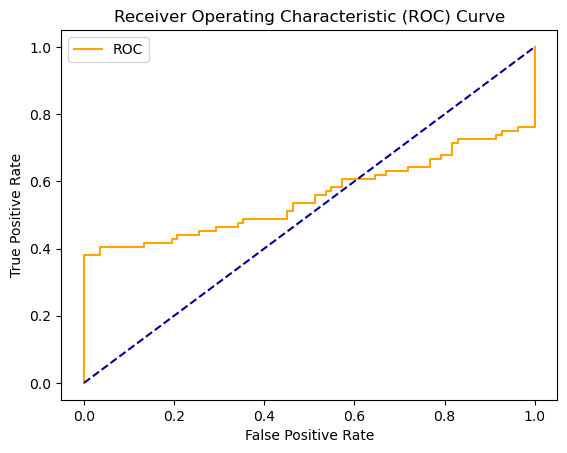

AUC: 0.555

Data splitted by random:
Precision: 0.881, recall: 0.881, F1-measure: 0.881



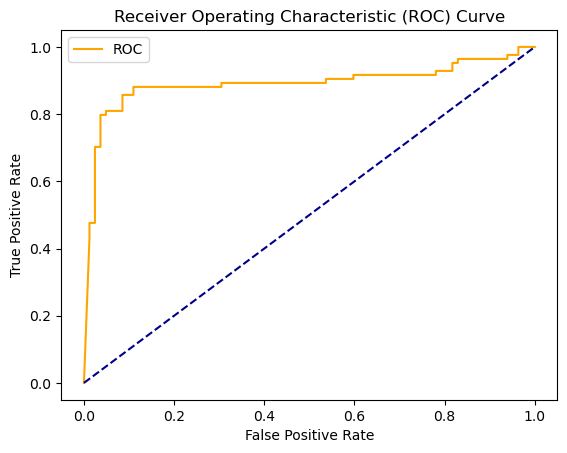

AUC: 0.891



In [10]:
print('Test validation:')
print('====== Evaluation summary ======')
# For the unshuffled data
y_test_pred_lr = lr_classifier.predict(x_test_mcv)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_test_pred_lr, average='binary')
print('Data splitted by time:')
print('Precision: {:.3f}, recall: {:.3f}, F1-measure: {:.3f}\n'.format(precision, recall, f1))

# AUC
y_test_pred_proba_lr = lr_classifier.predict_proba(x_test_mcv)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba_lr)
plot_roc_curve(fpr, tpr)
roc_auc = roc_auc_score(y_test, y_test_pred_proba_lr)
print('AUC: %.3f\n' % roc_auc)

# For the shuffled data
shuffled_y_test_pred_lr = shuffled_lr_classifier.predict(shuffled_x_test_mcv)
shuffled_precision, shuffled_recall, shuffled_f1, _ = precision_recall_fscore_support(shuffled_y_test, shuffled_y_test_pred_lr, average='binary')
print('Data splitted by random:')
print('Precision: {:.3f}, recall: {:.3f}, F1-measure: {:.3f}\n'.format(shuffled_precision, shuffled_recall, shuffled_f1))

# AUC
shuffled_y_test_pred_proba_lr = shuffled_lr_classifier.predict_proba(shuffled_x_test_mcv)[:,1]
fpr, tpr, thresholds = roc_curve(shuffled_y_test, shuffled_y_test_pred_proba_lr)
plot_roc_curve(fpr, tpr)
roc_auc = roc_auc_score(shuffled_y_test, shuffled_y_test_pred_proba_lr)
print('AUC: %.3f\n' % roc_auc)

# Constructing a decision tree model
Constructing a decision tree model using the *DecisionTreeClassifier* method from the **sklearn** library.

In [11]:
# Using the unshuffled data
dt_classifier = DecisionTreeClassifier(criterion='gini', max_depth=None,
                          max_features=None, class_weight=None)
dt_classifier.fit(x_train_mcv, y_train)

# Using the shuffled data
shuffled_dt_classifier = DecisionTreeClassifier(criterion='gini', max_depth=None,
                          max_features=None, class_weight=None)
shuffled_dt_classifier.fit(shuffled_x_train_mcv, shuffled_y_train)

DecisionTreeClassifier()

Test validation:
====== Evaluation summary ======
Data splitted by time:
Precision: 1.000, recall: 0.631, F1-measure: 0.774



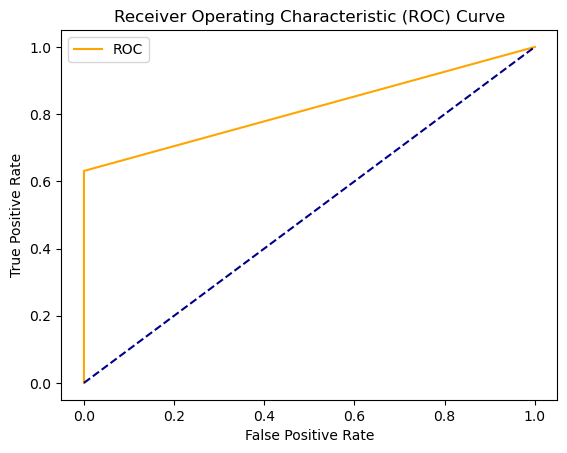

AUC: 0.815

Data splitted by random:
Precision: 0.975, recall: 0.929, F1-measure: 0.951



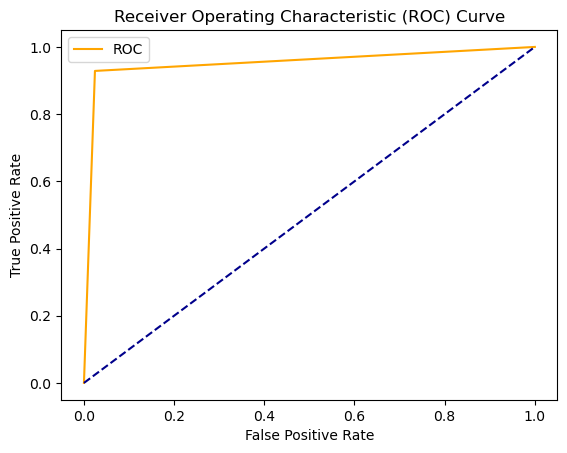

AUC: 0.952



In [12]:
print('Test validation:')
print('====== Evaluation summary ======')
# For the unshuffled data
y_test_pred_dt = dt_classifier.predict(x_test_mcv)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_test_pred_dt, average='binary')
print('Data splitted by time:')
print('Precision: {:.3f}, recall: {:.3f}, F1-measure: {:.3f}\n'.format(precision, recall, f1))

# AUC
y_test_pred_proba_dt = dt_classifier.predict_proba(x_test_mcv)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba_dt)
plot_roc_curve(fpr, tpr)
roc_auc = roc_auc_score(y_test, y_test_pred_proba_dt)
print('AUC: %.3f\n' % roc_auc)

# For the shuffled data
shuffled_y_test_pred_dt = shuffled_dt_classifier.predict(shuffled_x_test_mcv)
shuffled_precision, shuffled_recall, shuffled_f1, _ = precision_recall_fscore_support(shuffled_y_test, shuffled_y_test_pred_dt, average='binary')
print('Data splitted by random:')
print('Precision: {:.3f}, recall: {:.3f}, F1-measure: {:.3f}\n'.format(shuffled_precision, shuffled_recall, shuffled_f1))

# AUC
shuffled_y_test_pred_proba_dt = shuffled_dt_classifier.predict_proba(shuffled_x_test_mcv)[:,1]
fpr, tpr, thresholds = roc_curve(shuffled_y_test, shuffled_y_test_pred_proba_dt)
plot_roc_curve(fpr, tpr)
roc_auc = roc_auc_score(shuffled_y_test, shuffled_y_test_pred_proba_dt)
print('AUC: %.3f\n' % roc_auc)

# Constructing a random forest model
Constructing a random forest model using the *RandomForestClassifier* method from the **sklearn** library.

In [13]:
# Using the unshuffled data
rf_classifier = RandomForestClassifier(max_depth=None)
rf_classifier.fit(x_train_mcv, y_train)

# Using the shuffled data
shuffled_rf_classifier = RandomForestClassifier(max_depth=None)
shuffled_rf_classifier.fit(shuffled_x_train_mcv, shuffled_y_train)

RandomForestClassifier()

Test validation:
====== Evaluation summary ======
Data splitted by time:
Precision: 1.000, recall: 0.560, F1-measure: 0.718



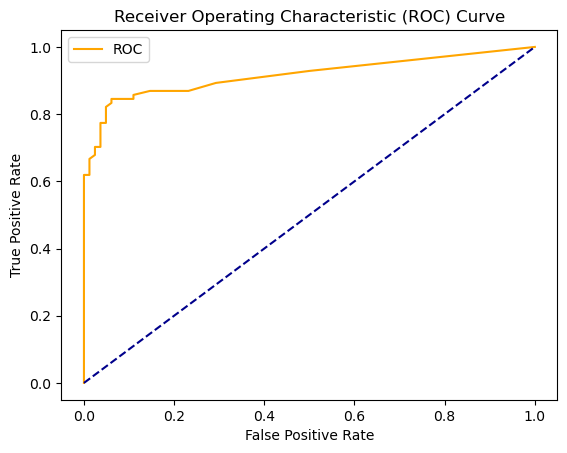

AUC: 0.916

Data splitted by random:
Precision: 0.935, recall: 0.857, F1-measure: 0.894



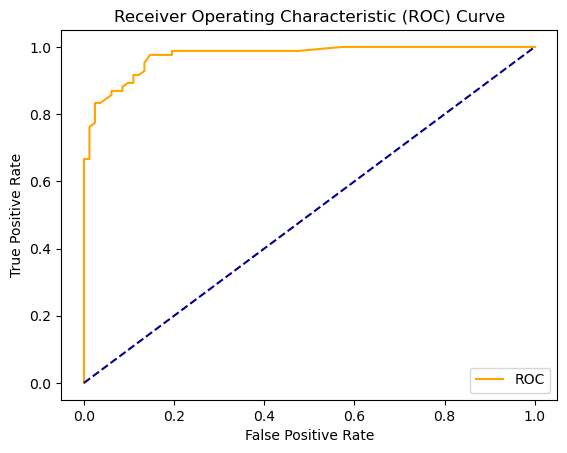

AUC: 0.974



In [14]:
print('Test validation:')
print('====== Evaluation summary ======')
# For the unshuffled data
y_test_pred_rf = rf_classifier.predict(x_test_mcv)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_test_pred_rf, average='binary')
print('Data splitted by time:')
print('Precision: {:.3f}, recall: {:.3f}, F1-measure: {:.3f}\n'.format(precision, recall, f1))

# AUC
y_test_pred_proba_rf = rf_classifier.predict_proba(x_test_mcv)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba_rf)
plot_roc_curve(fpr, tpr)
roc_auc = roc_auc_score(y_test, y_test_pred_proba_rf)
print('AUC: %.3f\n' % roc_auc)

# For the shuffled data
shuffled_y_test_pred_rf = shuffled_rf_classifier.predict(shuffled_x_test_mcv)
shuffled_precision, shuffled_recall, shuffled_f1, _ = precision_recall_fscore_support(shuffled_y_test, shuffled_y_test_pred_rf, average='binary')
print('Data splitted by random:')
print('Precision: {:.3f}, recall: {:.3f}, F1-measure: {:.3f}\n'.format(shuffled_precision, shuffled_recall, shuffled_f1))

# AUC
shuffled_y_test_pred_proba_rf = shuffled_rf_classifier.predict_proba(shuffled_x_test_mcv)[:,1]
fpr, tpr, thresholds = roc_curve(shuffled_y_test, shuffled_y_test_pred_proba_rf)
plot_roc_curve(fpr, tpr)
roc_auc = roc_auc_score(shuffled_y_test, shuffled_y_test_pred_proba_rf)
print('AUC: %.3f\n' % roc_auc)

# Constructing a MLP
Constructing a MLP using the *MLPClassifier* method from the **sklearn** library.

In [15]:
# Using the unshuffled data
mlp_classifier = MLPClassifier(max_iter=300).fit(x_train_mcv, y_train)

# Using the shuffled data
shuffled_mlp_classifier = MLPClassifier(max_iter=300).fit(shuffled_x_train_mcv, shuffled_y_train)

Test validation:
====== Evaluation summary ======
Data splitted by time:
Precision: 0.925, recall: 0.440, F1-measure: 0.597



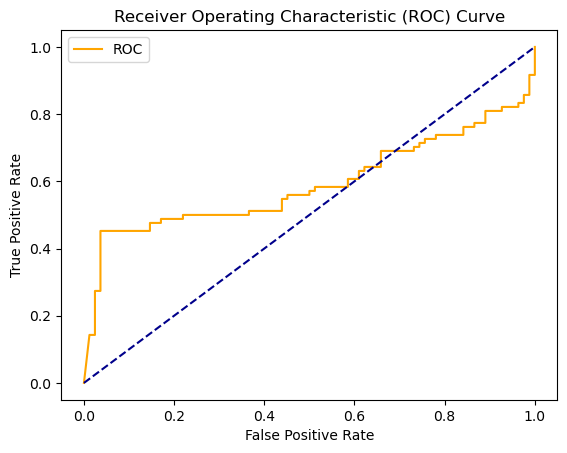

AUC: 0.591

Data splitted by random:
Precision: 0.796, recall: 0.881, F1-measure: 0.836



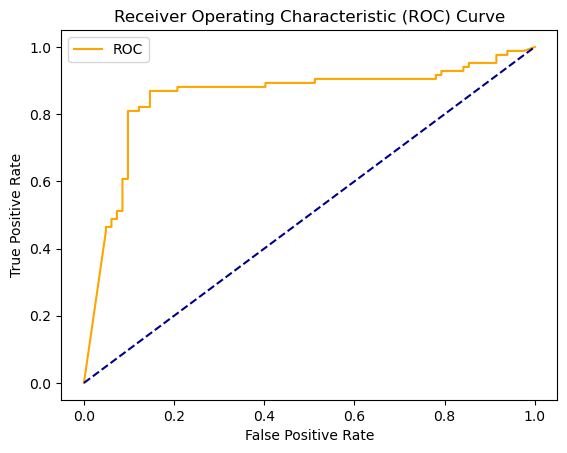

AUC: 0.852



In [16]:
print('Test validation:')
print('====== Evaluation summary ======')
# For the unshuffled data
y_test_pred_mlp = mlp_classifier.predict(x_test_mcv)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_test_pred_mlp, average='binary')
print('Data splitted by time:')
print('Precision: {:.3f}, recall: {:.3f}, F1-measure: {:.3f}\n'.format(precision, recall, f1))

# AUC
y_test_pred_proba_mlp = mlp_classifier.predict_proba(x_test_mcv)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba_mlp)
plot_roc_curve(fpr, tpr)
roc_auc = roc_auc_score(y_test, y_test_pred_proba_mlp)
print('AUC: %.3f\n' % roc_auc)

# For the shuffled data
shuffled_y_test_pred_mlp = shuffled_mlp_classifier.predict(shuffled_x_test_mcv)
shuffled_precision, shuffled_recall, shuffled_f1, _ = precision_recall_fscore_support(shuffled_y_test, shuffled_y_test_pred_mlp, average='binary')
print('Data splitted by random:')
print('Precision: {:.3f}, recall: {:.3f}, F1-measure: {:.3f}\n'.format(shuffled_precision, shuffled_recall, shuffled_f1))

# AUC
shuffled_y_test_pred_proba_mlp = shuffled_mlp_classifier.predict_proba(shuffled_x_test_mcv)[:,1]
fpr, tpr, thresholds = roc_curve(shuffled_y_test, shuffled_y_test_pred_proba_mlp)
plot_roc_curve(fpr, tpr)
roc_auc = roc_auc_score(shuffled_y_test, shuffled_y_test_pred_proba_mlp)
print('AUC: %.3f\n' % roc_auc)

# Extension 1: Extend the analyses performed in the replication. Perform the following analyses on one log dataset.

In [43]:
def resample(n):
    for _ in range(n):
        # Shuffle the data
        shuffled_data_df = data_df.sample(frac=1).reset_index(drop=True)
        shuffled_data_df.head(5)

        # Split train and test data
        train_ratio = 0.8
        (shuffled_x_train, shuffled_y_train), (shuffled_x_test, shuffled_y_test) = _split_data(shuffled_data_df['EventSequence'].values,
            shuffled_data_df['Label'].values, train_ratio)

        # Fit and transform the training data
        shuffled_count_vectorizer = CountVectorizer()
        shuffled_x_train_mcv = shuffled_count_vectorizer.fit_transform(shuffled_x_train)
        # Transform the testing data
        shuffled_x_test_mcv = shuffled_count_vectorizer.transform(shuffled_x_test)

        # Fit a linear regression model
        shuffled_lr_classifier = LogisticRegression(penalty='l2', C=100, tol=0.01, class_weight=None, max_iter=1000)
        shuffled_lr_classifier.fit(shuffled_x_train_mcv, shuffled_y_train)
        shuffled_y_test_pred_lr = shuffled_lr_classifier.predict(shuffled_x_test_mcv)
        _, _, shuffled_f1, _ = precision_recall_fscore_support(shuffled_y_test, shuffled_y_test_pred_lr, average='binary')
        lr_f1.append(shuffled_f1)

        # Fit a decision tree model
        shuffled_dt_classifier = DecisionTreeClassifier(criterion='gini', max_depth=None,
                              max_features=None, class_weight=None)
        shuffled_dt_classifier.fit(shuffled_x_train_mcv, shuffled_y_train)
        shuffled_y_test_pred_dt = shuffled_dt_classifier.predict(shuffled_x_test_mcv)
        _, _, shuffled_f1, _ = precision_recall_fscore_support(shuffled_y_test, shuffled_y_test_pred_dt, average='binary')
        dt_f1.append(shuffled_f1)

        # Fit a random forest model
        shuffled_rf_classifier = RandomForestClassifier(max_depth=None)
        shuffled_rf_classifier.fit(shuffled_x_train_mcv, shuffled_y_train)
        shuffled_y_test_pred_rf = shuffled_rf_classifier.predict(shuffled_x_test_mcv)
        _, _, shuffled_f1, _ = precision_recall_fscore_support(shuffled_y_test, shuffled_y_test_pred_rf, average='binary')
        rf_f1.append(shuffled_f1)

        # Fit a MLP
        shuffled_mlp_classifier = MLPClassifier(max_iter=300).fit(shuffled_x_train_mcv, shuffled_y_train)
        shuffled_y_test_pred_mlp = shuffled_mlp_classifier.predict(shuffled_x_test_mcv)
        _, _, shuffled_f1, _ = precision_recall_fscore_support(shuffled_y_test, shuffled_y_test_pred_mlp, average='binary')
        mlp_f1.append(shuffled_f1)

/home/swendart/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/swendart/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

,LR,DT,RF,MLP
0,0.802326,0.943396,0.918239,0.824242
1,0.857143,0.963855,0.907975,0.871166
2,0.900585,0.925926,0.888889,0.887500
3,0.797619,0.963415,0.944785,0.842105
4,0.830409,0.951220,0.897436,0.795455
5,0.891566,0.917197,0.924051,0.843373
6,0.851852,0.940476,0.902439,0.844720
7,0.923977,0.950617,0.914634,0.867052
8,0.857143,0.944785,0.925926,0.855346
9,0.848837,0.914634,0.887500,0.824242


<AxesSubplot:ylabel='AUC'>

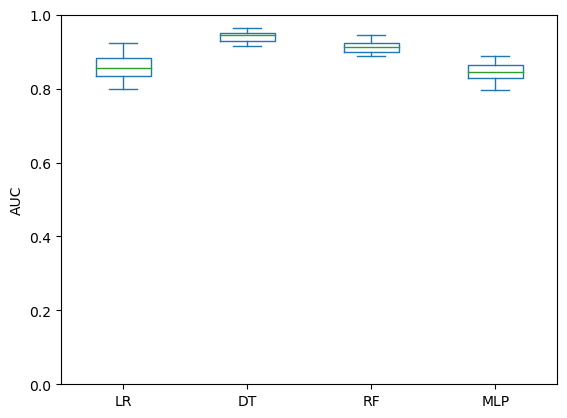

In [48]:
lr_f1, dt_f1, rf_f1, mlp_f1 = [], [], [], []

resample(10)

model_performance_df = pd.DataFrame()
model_performance_df['LR'] = lr_f1
model_performance_df['DT'] = dt_f1
model_performance_df['RF'] = rf_f1
model_performance_df['MLP'] = mlp_f1
model_performance_df.to_csv('result/BGL/model_performance.csv', index = False)
display(model_performance_df)
model_performance_df.plot(kind = 'box', ylim = (0, 1), ylabel = 'AUC')



In [49]:
from PIL import Image

# Open the .png image
image = Image.open("result/BGL/BGL_scottKnottTest.png")  # Replace "example.png" with your image file's path

# Show the image
image.show()

kf.service.services: KApplicationTrader: mimeType "x-scheme-handler/file" not found
kf.i18n.kuit: "Unknown subcue ':whatsthis,' in UI marker in context {@info:whatsthis, %1 the action's text}."
org.kde.kdegraphics.gwenview.lib: Unresolved mime type  "image/x-aptus-mos"
org.kde.kdegraphics.gwenview.lib: Unresolved mime type  "image/x-arq"
org.kde.kdegraphics.gwenview.lib: Unresolved mime type  "image/x-bay"
org.kde.kdegraphics.gwenview.lib: Unresolved mime type  "image/x-bmq"
org.kde.kdegraphics.gwenview.lib: Unresolved mime type  "image/x-cap"
org.kde.kdegraphics.gwenview.lib: Unresolved mime type  "image/x-cine"
org.kde.kdegraphics.gwenview.lib: Unresolved mime type  "image/x-cs1"
org.kde.kdegraphics.gwenview.lib: Unresolved mime type  "image/x-dc2"
org.kde.kdegraphics.gwenview.lib: Unresolved mime type  "image/x-drf"
org.kde.kdegraphics.gwenview.lib: Unresolved mime type  "image/x-dxo"
org.kde.kdegraphics.gwenview.lib: Unresolved mime type  "image/x-epson-eip"
org.kde.kdegraphics.gwe

In [ ]:
env ARCHFLAGS="-arch i386 -arch x86_64" pip install rpy2

# Extension 2: Explore feature importance

In [19]:
# Get the first 10 most important feature for the model trained by the shuffled data
importances = shuffled_rf_classifier.feature_importances_
sessions = shuffled_count_vectorizer.get_feature_names_out()
importance_rank = np.argsort(importances)[::-1]
print('The 10 most importance sessions based on mean decrease in impurity are:')
for i in range(10):
    index = importance_rank[i]
    print('Session: {}, Score: {:.3f}'.format(sessions[index], importances[index]))

The 10 most importance sessions based on mean decrease in impurity are:
Session: a31b789f, Score: 0.058
Session: 220716fc, Score: 0.052
Session: ad69fd32, Score: 0.033
Session: 04639923, Score: 0.030
Session: 8f4acfdd, Score: 0.026
Session: f80a5ed5, Score: 0.025
Session: a9208363, Score: 0.021
Session: 6b31e08c, Score: 0.021
Session: ce2b6cdc, Score: 0.019
Session: fb1560b4, Score: 0.018


# Extension 3: Apply correlation analysis (e.g., hierarchical clustering) and redundancy analysis (e.g., variance inflation factor, or VIF analysis) to remove collinearity and multi-collinearity among the features before constructing the models. Compare the performance of the models with and without this step.

# Note: If correlation between 2 variables is greater than 0.8, then we should remove one of them and train the model again.

# Once we complete this, we train the models on the data without correlation between variables and compare its performance with the ones we already trained earlier in this notebook


In [20]:
# This is 1st example of code, so we need to adapt

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Define your independent variables (features) without the target variable
X = data[['feature1', 'feature2', 'feature3']]

# Add a constant to the independent variables (required for VIF)
X = sm.add_constant(X)

# Calculate VIF for each feature
vif = pd.DataFrame()
vif["Feature"] = X.columns   
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Print or inspect the VIF values to identify multicollinear features
print(vif)


KeyError: "None of [Index(['feature1', 'feature2', 'feature3'], dtype='object')] are in the [columns]"

In [ ]:
# This is a 2nd example, so we need to adapt

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Load your dataset
data = pd.read_csv("your_data.csv")

# Step 1: Correlation Analysis
correlation_matrix = data.corr()

# Visualize the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# Step 2: Hierarchical Clustering
# Use hierarchical clustering to group highly correlated features
linkage_matrix = linkage(correlation_matrix, method='ward')

# Visualize the dendrogram
dendrogram(linkage_matrix, labels=correlation_matrix.columns, orientation='top')
plt.title("Hierarchical Clustering Dendrogram")
plt.show()

# Step 3: Redundancy Analysis (VIF Analysis)
# Define your independent variables (features) without the target variable
X = data[['feature1', 'feature2', 'feature3']]

# Add a constant to the independent variables (required for VIF)
X = sm.add_constant(X)

# Calculate VIF for each feature
vif = pd.DataFrame()
vif["Feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1)]

# Print or inspect the VIF values to identify multicollinear features
print("VIF Analysis Results:")
print(vif)

# You can now decide which features to retain, remove, or consolidate based on the results of these analyses.
